# Bootstrap analysis of all task's subtypes

In [6]:
import os
import numpy as np
import pandas as pd

In [1]:
# load good stuff
%matplotlib inline
%load_ext rpy2.ipython
%load_ext oct2py.ipython

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [10]:
#  Set path
path_root = '/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/pheno'

In [11]:
df_stack = pd.read_csv(os.path.join(path_root,'all_subtype_stack.csv'))

In [13]:
df_stack.head()

,sub1_fear,sub2_fear,sub3_fear,sub4_fear,sub5_fear,sub1_contrast_loss_event_vs_neut_event,sub2_contrast_loss_event_vs_neut_event,sub3_contrast_loss_event_vs_neut_event,sub4_contrast_loss_event_vs_neut_event,sub5_contrast_loss_event_vs_neut_event,...,sub1_places,sub2_places,sub3_places,sub4_places,sub5_places,sub1_2bk,sub2_2bk,sub3_2bk,sub4_2bk,sub5_2bk
0,-0.000026,-0.000010,3.400174e-06,1.969976e-05,0.000001,-2.722667e-04,0.000034,3.307610e-05,0.000092,-0.000035,...,7.089784e-05,0.000071,2.997301e-06,-0.000042,-0.000037,0.000049,-0.000026,0.000066,-0.000129,3.228139e-06
1,-0.000030,-0.000050,7.557251e-05,1.935898e-05,-0.000020,-2.416968e-05,-0.000024,-9.189761e-05,0.000128,-0.000043,...,5.864750e-05,-0.000017,3.228650e-05,-0.000051,-0.000006,0.000039,-0.000018,0.000081,-0.000160,8.092133e-06
2,-0.000037,-0.000062,2.097875e-04,-5.504649e-05,-0.000034,7.750296e-05,0.000105,-1.515700e-04,0.000077,-0.000081,...,3.866714e-05,0.000037,-2.390819e-06,0.000006,-0.000032,-0.000008,-0.000013,0.000030,-0.000075,3.030099e-05
3,0.000001,0.000018,-1.056633e-05,2.286825e-06,-0.000005,-8.490994e-06,0.000001,6.710994e-06,0.000010,-0.000013,...,-2.469192e-07,0.000003,-6.788072e-07,-0.000007,0.000003,0.000010,-0.000011,-0.000003,0.000002,2.005255e-06
4,-0.000007,0.000009,5.834449e-07,7.194440e-07,-0.000002,8.046937e-07,0.000002,5.579041e-07,-0.000009,0.000007,...,9.066289e-07,0.000009,-9.413969e-07,-0.000012,0.000003,0.000006,-0.000010,-0.000004,0.000011,4.487713e-07


In [70]:
# extract all table value
y = df_stack.loc[:].values
LABELS_Y = list(df_stack.columns.values)

In [71]:
# push it to octave
%octave_push y
%octave_push LABELS_Y
%octave LABELS_Y = LABELS_Y';

We compute the spatial correlation matrix (across subjects) to see how the cluster structure looks.  

ans =  1

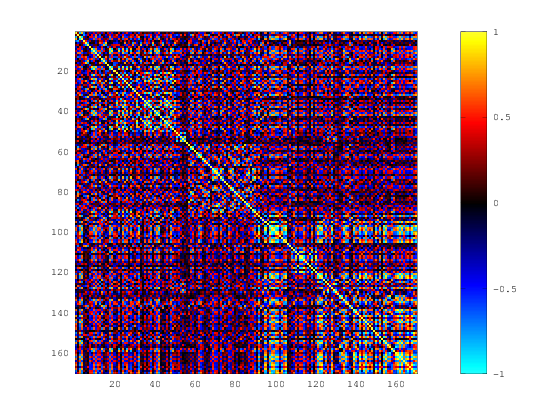

In [21]:
%%octave
nb_cluster =8;   %# of clusters 
R = corr(y);
title('Spatial correlation matrix')
niak_visu_matrix(R), axis square

the cluster structure is clear, but noisy. Let's run a hierarchical clustering and see if we can recover it. 

     Percentage done : 0 5 10 15 20 25 30 36 40 46 50 55 60 65 70 75 80 85 91 95 100 Done ! 

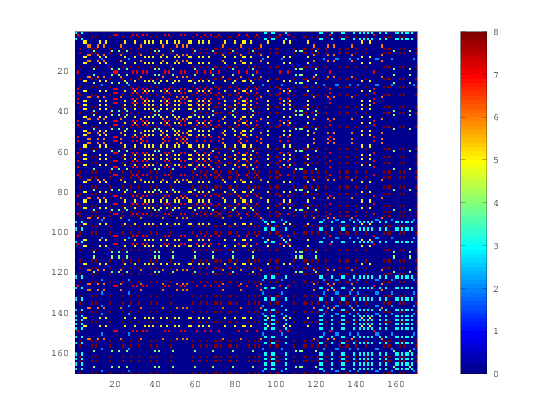

In [22]:
%%octave
hier = niak_hierarchical_clustering(R); % The similarity-based hierarchical clustering
part = niak_threshold_hierarchy(hier,struct('thresh',nb_cluster)); % threshold the hierarchy to get 3 clusters
niak_visu_part(part) % visualize the partition

If the clustering had done a perfect job, we would have squares on the diagonal.let's odre it

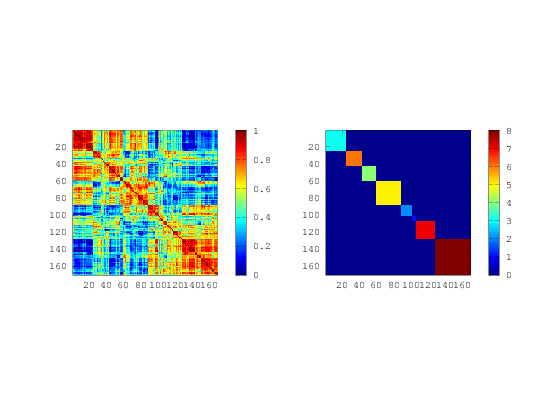

In [23]:
%%octave
order = niak_hier2order(hier); % order the regions based on the hierarchy
subplot(1,2,1)
% Re-order the correlation matrix
title('re-ordered correlation matrix')
imagesc(R(order,order)), axis square, colorbar
subplot(1,2,2)
% Show the re-ordered partition
title('re-ordered partition')
niak_visu_part(part(order)), axis square

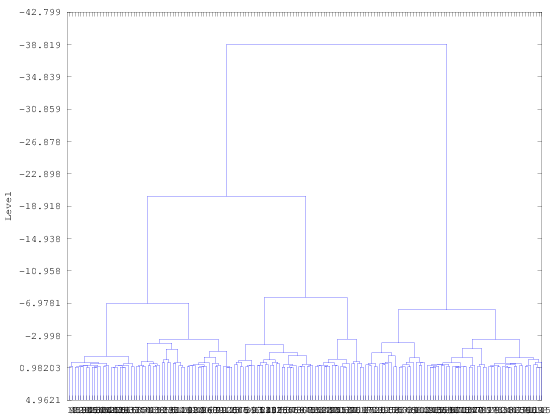

In [24]:
%octave niak_visu_dendrogram(hier)

## boostrap analysis of stable clusters
 

In [25]:
%%octave
nb_samp = 100;
opt_b.block_length = 1; % That's a parameter for the bootstrap. We treat the subjects as independent observations. 
for ss = 1:nb_samp
    niak_progress(ss,nb_samp)
    y_s = niak_bootstrap_tseries(y,opt_b); % Bootstrap the subjects
    R_s = corr(y_s); % compute the correlation matrix for the bootstrap sample
    hier = niak_hierarchical_clustering(R_s,struct('flag_verbose',false)); % replication the hierarchical clustering
    part = niak_threshold_hierarchy(hier,struct('thresh',nb_cluster)); % Cut the hierarchy to get clusters
    mat = niak_part2mat(part,true); % convert the partition into an adjacency matrix
    if ss == 1; stab = mat; else stab = stab+mat; end; % Add all adjacency matrices
end
stab = stab / nb_samp; % Divide by the number of replications to get the stability matrix

    Percentage done: 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100

Let's have a look at the stability matrix:

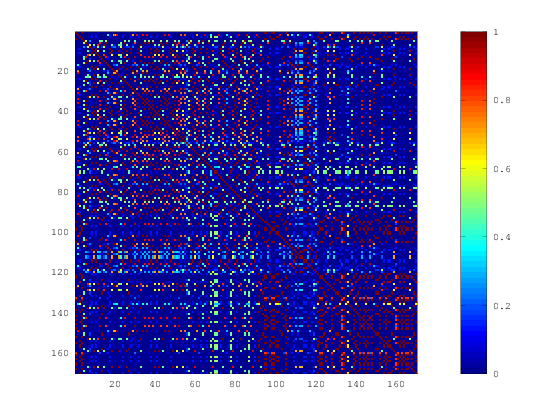

In [27]:
%octave imagesc(stab), axis square, colormap(jet), colorbar

     Percentage done : 0 5 10 15 20 25 30 36 40 46 50 55 60 65 70 75 80 85 91 95 100 Done ! 

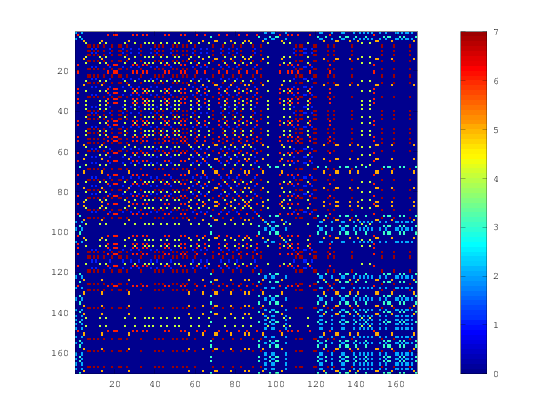

In [76]:
%%octave
nb_cluster =7;   % # of clusters 
hier_consensus = niak_hierarchical_clustering(stab); % run a hierarchical clustering on the stability matrix
part_consensus = niak_threshold_hierarchy(hier_consensus,struct('thresh',nb_cluster)); % cut the consensus hierarchy
niak_visu_part(part_consensus), axis square, colormap(jet) % visualize the consensus partition

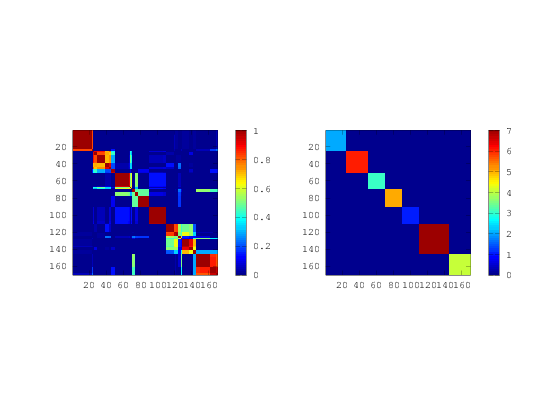

In [77]:
%%octave
order_consensus = niak_hier2order(hier_consensus); % order the regions based on the hierarchy
subplot(1,2,1)
% Re-order the correlation matrix
title('re-ordered consensus matrix')
imagesc(stab(order_consensus,order_consensus)), axis square, colorbar
subplot(1,2,2)
% Show the re-ordered partition
title('re-ordered partition')
niak_visu_part(part_consensus(order_consensus)), axis square

In [78]:
%niak_visu_dendrogram(hier_consensus)

ERROR:root:Line magic function `%niak_visu_dendrogram` not found.


ans =  1

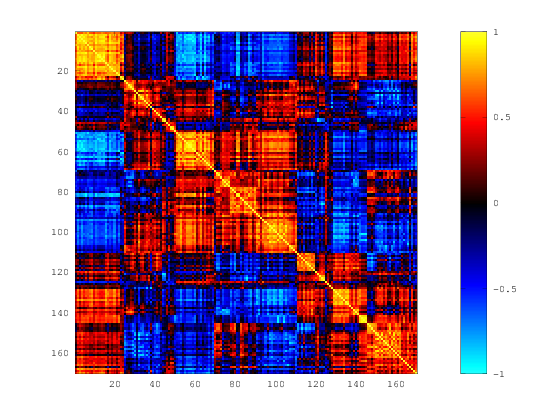

In [79]:
%%octave
% Re-order the correlation matrix
title('re-ordered correlation matrix')
niak_visu_matrix(R(order_consensus,order_consensus)), axis square, colorbar


In [80]:
%%octave
% calculate the mean cluster and save it
stack = [];
labels_y_order = LABELS_Y( order_consensus);
part_consensus_order = part_consensus(order_consensus);
y_order = y(:,order_consensus);
for ii = 1:nb_cluster
    fprintf('Cluster %i: \n',ii);
    label_y{ii} = sprintf('cluster_%i',ii);
    mask = zeros(size(part_consensus_order));
    mask = part_consensus_order == ii;
    mean_clust = mean(y_order(:,mask),2);
    stack = [stack mean_clust];
    labels_pheno = labels_y_order(mask);
    for ss = 1:size(labels_pheno)(1)
        fprintf('     %s \n',labels_pheno{ss})
    end
end
% save clustred pheno to csv
%opt.labels_y = label_y;
%opt.labels_x  = LABELS_X;
%opt.labels_id = 'Subject';
%niak_write_csv('/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/pheno/hcp_bootstraped_pheno_nonan_norm.csv',...
%stack,opt);

Cluster 1: 

     sub4_contrast_loss_event_vs_neut_event 

     sub3_lf 

     sub5_mental 

     sub2_loss 

     sub2_rh 

     sub5_rf 

     sub3_win_event 

     sub1_contrast_win_vs_loss 

     sub4_neut_event 

     sub1_win 

     sub4_mental 

     sub3_contrast_win_event_vs_neut_event 

     sub3_contrast_win_event_vs_loss_event 

     sub3_rnd 

     sub3_loss_event 

     sub3_t 

     sub4_contrast_rh_vs_lh 

     sub1_contrast_rf_vs_lf 

     sub1_lh 

     sub4_contrast_mental_vs_rnd 

Cluster 2: 

     sub1_fear 

     sub3_relation 

     sub2_tools 

     sub5_match 

     sub2_0bk 

     sub1_2bk 

     sub4_fear 

     sub5_contrast_relation_vs_match 

     sub4_relation 

     sub5_places 

     sub3_2bk 

     sub4_contrast_tools_vs_places 

     sub1_places 

     sub5_body 

     sub3_places 

     sub3_contrast_2bk_vs_0bk 

     sub3_faces 

     sub3_tools 

     sub4_0bk 

     sub4_contrast_faces_vs_places 

     sub1_faces 

     sub2_body 

     sub3_contrast_faces_vs_places 

     sub5_contrast_body_vs_places 

Cluster 3: 

     sub3_fear 

     sub5_contrast_faces_vs_places 

     sub2_contrast_relation_vs_match 

     sub5_contrast_tools_vs_places 

     sub1_tools 

     sub5_2bk 

     sub1_match 

     sub2_relation 

     sub5_0bk 

     sub4_body 

     sub2_contrast_body_vs_places 

     sub4_places 

     sub5_relation 

     sub2_contrast_faces_vs_places 

     sub2_places 

     sub1_contrast_body_vs_places 

     sub5_tools 

     sub3_lh 

     sub1_contrast_tools_vs_places 

Cluster 4: 

     sub1_contrast_loss_event_vs_neut_event 

     sub1_contrast_win_event_vs_neut_event 

     sub4_loss_event 

     sub2_contrast_mental_vs_rnd 

     sub5_neut_event 

     sub2_loss_event 

     sub4_contrast_rf_vs_lf 

     sub1_win_event 

     sub3_rf 

     sub3_contrast_rh_vs_lh 

     sub2_lh 

     sub5_win_event 

     sub5_rh 

     sub5_loss 

     sub5_lf 

     sub3_win 

     sub3_contrast_win_vs_loss 

     sub2_story 

     sub1_rnd 

     sub3_0bk 

     sub2_t 

     sub1_relation 

     sub4_match 

     sub5_contrast_win_event_vs_loss_event 

     sub2_faces 

Cluster 5: 

     sub5_fear 

     sub2_contrast_rh_vs_lh 

     sub5_contrast_rf_vs_lf 

     sub4_t 

     sub5_lh 

     sub1_lf 

     sub3_rh 

     sub2_rf 

     sub4_contrast_win_vs_loss 

     sub1_body 

     sub2_contrast_tools_vs_places 

     sub5_faces 

     sub4_2bk 

     sub4_contrast_relation_vs_match 

     sub2_contrast_win_event_vs_loss_event 

     sub4_tools 

     sub5_contrast_2bk_vs_0bk 

     sub3_match 

     sub3_contrast_body_vs_places 

     sub1_contrast_faces_vs_places 

     sub1_0bk 

Cluster 6: 

     sub2_fear 

     sub5_t 

     sub2_lf 

     sub1_rf 

     sub2_contrast_rf_vs_lf 

     sub1_neut_event 

     sub4_faces 

     sub1_loss 

     sub2_win_event 

     sub1_loss_event 

     sub1_contrast_relation_vs_match 

     sub5_win 

     sub2_match 

     sub4_loss 

     sub5_contrast_win_event_vs_neut_event 

     sub2_contrast_2bk_vs_0bk 

     sub4_contrast_win_event_vs_loss_event 

     sub1_t 

     sub1_contrast_mental_vs_rnd 

     sub3_story 

     sub5_story 

     sub2_contrast_win_event_vs_neut_event 

     sub1_rh 

     sub1_mental 

     sub2_rnd 

     sub3_contrast_mental_vs_rnd 

Cluster 7: 

     sub2_contrast_loss_event_vs_neut_event 

     sub3_body 

     sub4_win 

     sub3_contrast_rf_vs_lf 

     sub3_loss 

     sub5_contrast_win_vs_loss 

     sub3_contrast_relation_vs_match 

     sub4_lf 

     sub3_contrast_tools_vs_places 

     sub2_contrast_win_vs_loss 

     sub1_story 

     sub4_story 

     sub1_contrast_2bk_vs_0bk 

     sub4_contrast_2bk_vs_0bk 

     sub3_contrast_loss_event_vs_neut_event 

     sub4_rnd 

     sub1_contrast_rh_vs_lh 

     sub3_neut_event 

     sub5_contrast_loss_event_vs_neut_event 

     sub1_contrast_win_event_vs_loss_event 

     sub4_contrast_body_vs_places 

     sub4_contrast_win_event_vs_neut_event 

     sub5_loss_event 

     sub2_win 

     sub4_win_event 

     sub2_neut_event 

     sub2_2bk 

     sub5_contrast_rh_vs_lh 

     sub4_lh 

     sub4_rh 

     sub4_rf 

     sub5_contrast_mental_vs_rnd 

     sub2_mental 

     sub3_mental 

     sub5_rnd 

ans =  1

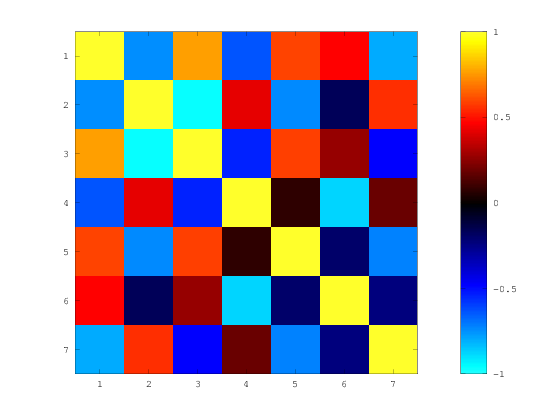

In [81]:
%%octave
Rc = corr(stack);
title('Spatial correlation matrix of clustered pheno')
niak_visu_matrix(Rc), axis square

In [82]:
%octave Rc

Rc =

   1.000000  -0.748700   0.759046  -0.638472   0.586761   0.468579  -0.804280

  -0.748700   1.000000  -0.967048   0.416789  -0.734478  -0.171422   0.549382

   0.759046  -0.967048   1.000000  -0.540324   0.585764   0.269798  -0.477886

  -0.638472   0.416789  -0.540324   1.000000   0.071575  -0.877766   0.187299

   0.586761  -0.734478   0.585764   0.071575   1.000000  -0.202765  -0.725174

   0.468579  -0.171422   0.269798  -0.877766  -0.202765   1.000000  -0.238230

  -0.804280   0.549382  -0.477886   0.187299  -0.725174  -0.238230   1.000000